In [1]:
import os
import torch
import re
import pandas as pd

from collections import OrderedDict
import numpy as np

from transformers import BertTokenizer
from transformers import BertModel
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, spearmanr
torch.set_num_threads(os.cpu_count())

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained('bert-large-uncased',output_hidden_states=True)
cosim = pd.read_csv('/home/shivani/Downloads/A Resource for Evaluating Graded Word Similarity in Context_ CoSimLex/cosimlex_en.csv', sep='\t')

In [3]:
sim_all_gold = np.array(cosim['sim1'].to_list() + cosim['sim2'].to_list())

In [157]:
for i in wn.synsets('absent'):
    print(i.definition())

go away or leave
not being in a specified place
nonexistent
lost in thought; showing preoccupation


In [4]:
from nltk.corpus import wordnet as wn

In [5]:
def auxillary_finder(word):
    all_tensor = []
    for i in wn.synsets(word)[:3]:
        sentence = word + ' is ' + (i.definition())
        outputs, y = BERTembedd(sentence, [0], only_embed=True)
        hidden_states = outputs[2]
        token_embeddings = torch.stack(hidden_states, dim=0)
        token_embeddings.size()
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        f_v = torch.mean(token_embeddings[-4:], dim=0)
#         print (y[1]['pos'])
        final_tensor = torch.mean(f_v[y[1]['pos']], dim=0)
        all_tensor.append(final_tensor)
    return all_tensor 


In [6]:
def sense_finder(word, original_embedding):
    all_tensor = auxillary_finder(word)
    if len(all_tensor) == 0:
        return original_embedding
    else:
        cdist = []
        for sense_embed in all_tensor:
            cdist.append(cosine(sense_embed, original_embedding))
        cdist = np.array(cdist)
        lowest_cdist_idx = np.argsort(cdist)[0]
        print (cdist, lowest_cdist_idx)
        return torch.mean(torch.stack([all_tensor[lowest_cdist_idx], original_embedding]), dim=0)
    

In [7]:
def filtered_token_pos(context):
    key_pos = []
    key = []
    for idx, i in enumerate(context.split()):
        if i.startswith('<'):
            key.append(re.findall('>(\w+)<', i)[0])
            key_pos.append(idx)
        else:
            key.append(i)
    #         print(key, key_pos)
    text = ' '.join(key)
    return key, key_pos

In [8]:
def BERTembedd(text, key_pos, only_embed=False):
    marked_text = "[CLS] " + text + " [SEP]"
    # Split the sentence into tokens.
    tokenized_text = tokenizer.tokenize(marked_text)
    mapping = OrderedDict()
    start = 0
    for idx, i in enumerate(marked_text.split()):
       token = tokenizer.tokenize(i)
       mapping[idx] = {'token' : token, 
                    'pos' : np.arange(start, start+len(token)), 
                      'oword' : i}
       start += len(token)

    final_mask = []
    for i in mapping.items():
       final_mask += (i[1]['token'])



    # Map the token strings to their vocabulary indeces.
    indexed_tokens = tokenizer.convert_tokens_to_ids(final_mask)
    tokens_tensor = torch.tensor([indexed_tokens])
    tokens_tensor

    #Run the text through BERT, get the output and collect all of the hidden states produced from all 12 layers.
    with torch.no_grad():
          outputs = model(tokens_tensor)                    
    if only_embed:
        return outputs, mapping
    hidden_states = outputs[2]
    token_embeddings = torch.stack(hidden_states, dim=0)  
#     print(token_embeddings.shape)
    token_embeddings = torch.squeeze(token_embeddings[-4:], dim=1)
    f_v = torch.mean(token_embeddings, dim=0)
    new_t0 = sense_finder(mapping[key_pos[0]+1]['oword'] , torch.mean(f_v[mapping[key_pos[0]+1]['pos']], dim=0))
    new_t1 = sense_finder(mapping[key_pos[1]+1]['oword'] , torch.mean(f_v[mapping[key_pos[1]+1]['pos']], dim=0))
    similarity = cosine(new_t0, new_t1)
    similarity_ = cosine(torch.mean(f_v[mapping[key_pos[0]+1]['pos']], dim=0),
                    torch.mean(f_v[mapping[key_pos[1]+1]['pos']], dim=0))

    return similarity, similarity_

In [9]:
sim_val_c1 = []
sim_val_orig_c1 = []
for idx, row in enumerate(cosim.itertuples()):
#     if idx>3:
#         break
    val = (row.context1.lower())
    key, key_pos = filtered_token_pos(val)
#     print(key, key_pos)
    if len(key_pos) != 2:
#         print (val)
        sim = 0.5
        sim_=0.5
        print("Skipping")
    else:
        sim, sim_ = BERTembedd(' '.join(key), key_pos)
#         print (idx, sim)/
    sim_val_c1.append(round(sim, 4))
    sim_val_orig_c1.append(round(sim_, 4))

[0.38419515 0.37177831 0.39643812] 1
[0.41824102 0.41710567 0.4177956 ] 1
[0.24855578 0.29717106 0.29073799] 0
[0.34138215 0.32808    0.321747  ] 2
[0.42162108 0.32697421 0.3462438 ] 1
[0.40758079 0.41110462 0.4056415 ] 2
[0.29997462 0.31053126 0.31256258] 0
[0.29538894 0.26362604] 1
[0.27488381 0.26178199 0.33350849] 1
[0.33222824 0.35966307 0.37932569] 0
[0.40311617 0.38988173 0.40583682] 1
[0.36552966 0.38005966 0.36816472] 0
[0.3452552] 0
[0.28442997 0.28089857] 1
[0.5295051  0.5026955  0.43012792] 2
[0.36531717 0.38295287 0.35600513] 2
[0.28271472] 0
[0.37997729 0.32778484] 1
[0.45583463 0.32984579 0.38574713] 1
[0.33834493 0.30334306 0.37937111] 1
[0.18219095 0.18703622 0.19505525] 0
[0.20288926 0.1981591  0.1718424 ] 2
[0.35902619 0.30530757 0.29255974] 2
[0.36050087 0.26571417 0.37251955] 1
[0.35714662 0.36477721] 0
[0.25724965 0.29162931] 0
[0.20577645 0.27596766] 0
[0.18969178 0.24833083 0.30020273] 0
[0.21228629] 0
[0.27333027 0.32263881] 0
[0.207748   0.23967677] 0
[0.20874

[0.20958668 0.19953942 0.20721704] 1
[0.23719925 0.35057843 0.3364284 ] 0
[0.21721792 0.34119618 0.22317427] 0
[0.27884531] 0
[0.29794222 0.37821978 0.44695908] 0
[0.3279072  0.33847356 0.37157327] 0
[0.24917775 0.25316131 0.24100453] 2
[0.19511455 0.21492052 0.20697373] 0
[0.12531877 0.16397536] 0
[0.22864789 0.23677886 0.25684792] 0
[0.3282845  0.35911375 0.31964356] 2
[0.34849691 0.2645722  0.35566252] 1
[0.34358871 0.39899969 0.37356013] 0
[0.41199684 0.3324818  0.34422922] 1
[0.28911912 0.28291994] 1
[0.1689629] 0
[0.35135305 0.35346586] 0
[0.21606559 0.17936438] 1
[0.31659949 0.31422776 0.35603952] 1
[0.25807095 0.21206731] 1
[0.26754928 0.28863126 0.35357136] 0
[0.37673628 0.39123064 0.35410118] 2
[0.33185816 0.3399362  0.34370053] 0
[0.4308632  0.44423866 0.26177424] 2
[0.45079863 0.44069332 0.44904417] 1
[0.28720969 0.29265594 0.286726  ] 2
[0.3031655  0.30510771] 0
[0.22956079 0.25210625 0.2108463 ] 2
[0.33327347] 0
[0.48961985 0.4934693  0.54208812] 0
[0.43306923 0.33402085 

[0.30125439 0.26833564 0.37789381] 1
[0.33517814] 0
[0.30871606 0.39042592 0.2786833 ] 2
[0.49832624 0.41728479 0.42512733] 1
[0.46575594 0.43352151 0.42779261] 2
[0.18789822 0.23522931 0.20832932] 0
[0.29701209 0.31952065 0.30748051] 0
[0.23416513] 0
[0.28855395 0.28351057 0.28180134] 2
[0.2479437  0.39737016 0.38954556] 0
[0.21983612 0.19051719 0.1916399 ] 1
[0.29338241 0.26400077 0.27583098] 1
[0.36005521 0.36997294 0.38218576] 0
[0.27929014] 0
[0.35066998 0.42351788 0.43437594] 0
[0.30618483 0.2476207  0.34245557] 1
[0.322851   0.40151089 0.39620364] 0
[0.34573078 0.26959062 0.32405162] 1
[0.1633631  0.18918031 0.14720249] 2
[0.35611635 0.34004289 0.39829969] 1
[0.37615407 0.30974567 0.39214319] 1
[0.32862854 0.40413481 0.38716072] 0
[0.17535287 0.17740709 0.18513697] 0
[0.30582654 0.30917645 0.36611187] 0
[0.18179417 0.18140876 0.17346001] 2
[0.32136291 0.32443589 0.28242218] 2
[0.46121448 0.4667272  0.48843288] 0
[0.30052167 0.23573434 0.25934285] 1
[0.39948207 0.43494552 0.41261

In [10]:
sim_val_c2 = []
sim_val_orig_c2 = []
for idx, row in enumerate(cosim.itertuples()):
#     if idx>3:
#         break
    val = (row.context2.lower())
    key, key_pos = filtered_token_pos(val)
#     print(key, key_pos)
    if len(key_pos) != 2:
#         print (val)
        sim = 0.5
        sim_=0.5
        print("Skipping")
    else:
        sim, sim_ = BERTembedd(' '.join(key), key_pos)
#         print (idx, sim)/
    sim_val_c2.append(round(sim, 4))
    sim_val_orig_c2.append(round(sim_, 4))

[0.44346553 0.39845705 0.42844921] 1
[0.39201671 0.385355   0.40721327] 1
[0.37828904 0.336357   0.35452849] 1
[0.38153368 0.38085777 0.41726941] 1
[0.3350628  0.36832213 0.40114677] 0
[0.3507055  0.47608232 0.35591698] 0
[0.34345758 0.33719963 0.35625696] 1
[0.32979226 0.37816286] 0
[0.36393207 0.37373412 0.37472063] 0
[0.38669902 0.40288812 0.39067066] 0
[0.46132869 0.43874282 0.44027203] 1
[0.30912894 0.30602616 0.28144813] 2
[0.31672388] 0
[0.23568237 0.24717569] 0
[0.3032946  0.27301955 0.25319397] 2
[0.52438846 0.46128148 0.44194287] 2
[0.32709074] 0
[0.26166147 0.31541175 0.3001067 ] 0
[0.35905963 0.3328681  0.37706715] 1
[0.36200726 0.33500522 0.32476389] 2
[0.31139177 0.32127249 0.31140447] 0
[0.34763575 0.33632517 0.28436989] 2
[0.27326322 0.27063143 0.22729433] 2
[0.25179064 0.26114905 0.27872729] 0
[0.23104066 0.26313996] 0
[0.13721663 0.15230304] 0
[0.17655307 0.16338277] 1
[0.13590765 0.22122902 0.29526448] 0
Skipping
[0.22978061 0.20848298 0.18129569] 2
[0.23284149 0.264

[0.17889768 0.20073301 0.17521834] 2
[0.3087976] 0
[0.26447856 0.34709311 0.40899086] 0
[0.25862491 0.24197543 0.26122433] 1
[0.53266937 0.51504982 0.53137666] 1
[0.19117683 0.16627222] 1
[0.30505949 0.30552822 0.32102263] 0
[0.35455489 0.42882198 0.36082643] 0
[0.3634907  0.36801797 0.36288321] 2
[0.28544271 0.30151635 0.33019257] 0
[0.22100621 0.30328417 0.23175955] 0
[0.24708521 0.27076495] 0
[0.39856815 0.29851222 0.34427655] 1
[0.12652647] 0
[0.17943621 0.22261947] 0
[0.17748994 0.16209912 0.22341162] 1
[0.20958197 0.21295148] 0
[0.18548846 0.17103791] 1
[0.26285857 0.27746677 0.40436876] 0
[0.3693434  0.32531404 0.33461893] 1
[0.38941896 0.36714756 0.41396695] 1
[0.51568055 0.54319534 0.41321194] 2
[0.39374822 0.34973478 0.3661502 ] 1
[0.28821319 0.28262049] 1
[0.38359183 0.33952987 0.35773712] 1
[0.32645041 0.43303734 0.30611384] 2
[0.35561442] 0
[0.55788532 0.57227969 0.62018394] 0
[0.42570382 0.41259509 0.4238106 ] 1
[0.24868077] 0
[0.36993849 0.45044804 0.28393692] 2
[0.33208

[0.48362637 0.44037873 0.46567601] 1
[0.25760108 0.38812947 0.32092285] 0
[0.25555384 0.24252951 0.28988636] 1
[0.20284241 0.33834636 0.26189035] 0
[0.20456105 0.24928433 0.338337  ] 0
[0.22965759 0.37603557 0.3282305 ] 0
[0.16945291 0.22385061 0.176718  ] 0
[0.41940272 0.35360229 0.34174991] 2
[0.33344769 0.28592598 0.32501268] 1
[0.28192723 0.32301909 0.29871053] 0
[0.29565763 0.20477343 0.34876275] 1
[0.33642393] 0
[0.3131426  0.40998107 0.31152773] 2
[0.42445427 0.42800218 0.42265767] 2
[0.4704507  0.40686291 0.39827669] 2
[0.32060128 0.33377695 0.33898187] 0
[0.27351618 0.28889793 0.24937588] 2
[0.25827467] 0
[0.28719193 0.35093164 0.33266979] 0
[0.41877365 0.43027705 0.39512181] 2
[0.38316685 0.34263343 0.32494885] 2
[0.28444111 0.31471199 0.33917779] 0
[0.32346088 0.31905621 0.28014404] 2
[0.15733844] 0
[0.45580733 0.36777025 0.32936829] 2
[0.19983792 0.30489671 0.31758803] 0
[0.26845968 0.35911274 0.36555064] 0
[0.53182706 0.4202323  0.47236079] 1
[0.42369932 0.44609863 0.36318

In [90]:
sim_val = sim_val_c1 + sim_val_c2
sim_val_orig = sim_val_orig_c1 + sim_val_orig_c2

In [91]:
sim_val_new = 1- np.array(sim_val)
sim_val_old = 1 -np.array(sim_val_orig)

In [128]:
fval = sim_val_new

In [129]:
fval[fval==0.5]=0

In [130]:
a = spearmanr(fval, sim_all_gold)[0]

In [131]:
b = pearsonr(fval, sim_all_gold)[0]

In [132]:
a , b

(0.7359624805025201, 0.5148004894801397)

In [133]:
(2*a * b )/(a+b)

0.6058283692344485

In [18]:
import matplotlib.pyplot as plt

In [139]:
k = (np.arange(1,8)) 
val = [0.708543639318338,
0.715703097951766,
0.714931227518415,
0.71012505051737,
0.705548402658012,
0.709897838146405,
0.708553045773603
]
k1 = [0.74335000181007,
0.760643179494952,
0.761632542738071,
0.759884432182709,
0.760826773631816,
0.760035207804701,
0.761980029021642
]

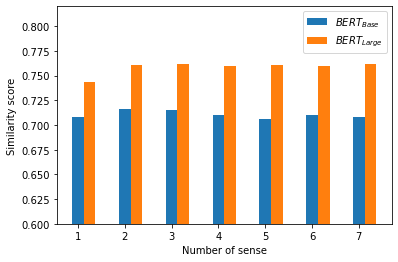

In [154]:
# plt.figure(5,7)
plt.bar(k, val, width=0.25, label='$BERT_{Base}$')
plt.bar(k+0.25, k1, width=0.25, label='$BERT_{Large}$')
plt.ylim(0.6,0.82)
plt.ylabel('Similarity score')
plt.xlabel('Number of sense')
plt.legend(loc='upper right')
# plt.plot(k,val, 'ro--', linewidth=2, markersize=3)
# plt.plot(k+0.25,k1, 'go--', linewidth=2, markersize=3)
plt.savefig('Sensevariation.png', bbox_inches='tight')


In [ ]:
(0.6132352848151187 + 0.5919311205551058)/2

In [ ]:
s = sim_val

In [ ]:
s

In [ ]:
fval[fval==0.3] = 0.7